# Image Analysis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

from sklearn.cluster import MiniBatchKMeans
from scipy.spatial import cKDTree
from joblib import Parallel, delayed

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.stats import linregress, pearsonr

In [2]:
data_dir = "../data/oct24_clean/"

games = pd.read_csv(data_dir + "games.csv")
genres = pd.read_csv(data_dir + "genres_translated.csv")
spy = pd.read_csv(data_dir + "steamspy_insights.csv") 
prom = pd.read_csv(data_dir + "promotional.csv")

In [3]:
df = pd.read_csv(data_dir + "ge-10_concurrent-users.csv")
df

app_id
0     1126290
1     2643960
2      865680
3       22500
4      880950
...       ...
6169  1172470
6170  1203220
6171      570
6172   578080
6173      730

[6174 rows x 1 columns]

## Load Images

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path)  # Loads image in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    return image

image_dir = "../data/img/header"

images = []
keys = dict()

for i, app_id in enumerate(df.app_id):
    images.append(load_image(f"{image_dir}/{app_id}.jpg"))
    keys[app_id] = i

In [5]:
def show_images(imgs):
    fig, axes = plt.subplots(3, 2, figsize=(8, 6))
    for i, ax in enumerate(axes.reshape(-1)):
        ax.imshow(imgs[i])
    plt.tight_layout()

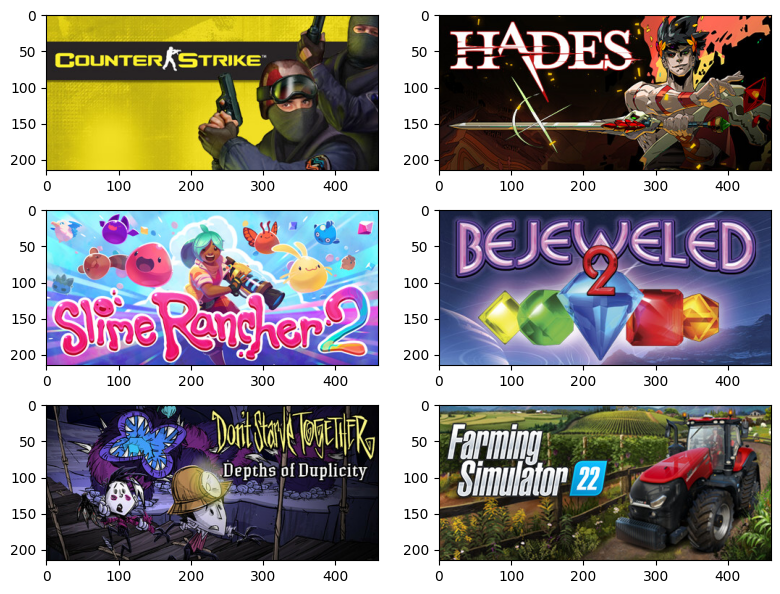

In [6]:
# example_ids = [10, 1366540, 322330, 238460,]
example_ids = [10, 1145360, 1657630, 3300, 322330, 1248130]

# example_ids = np.random.choice(df.app_id, size=(6,))
show_images([images[keys[id]] for id in example_ids])

## Dominant Colors (K-Means Quantization)

***Computation***

In [ ]:
def find_top_colors(image_array, k):
    """Find k dominant colors using MiniBatchKMeans for speed."""
    kmeans = MiniBatchKMeans(n_clusters=k, n_init=3, batch_size=1000)  
    kmeans.fit(image_array)
    return kmeans.cluster_centers_

def replace_colors(image_array, top_colors):
    """Replace each pixel with the closest top color using cKDTree."""
    tree = cKDTree(top_colors)
    _, indices = tree.query(image_array)  # Find closest colors
    return top_colors[indices]

def rgb_to_lab(image_array):
    """Convert RGB image to LAB color space for better clustering."""
    return cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB).reshape(-1, 3)

def process_image(img, k):
    """Pipeline for a single image."""
    flat_lab = rgb_to_lab(img)
    top_colors = find_top_colors(flat_lab, k)
    return top_colors

In [8]:
# Process images in parallel
k = 8
knn_colors = Parallel(n_jobs=-1, backend="loky")(
    delayed(process_image)(img, k) for img in images)

Quantization: k=8


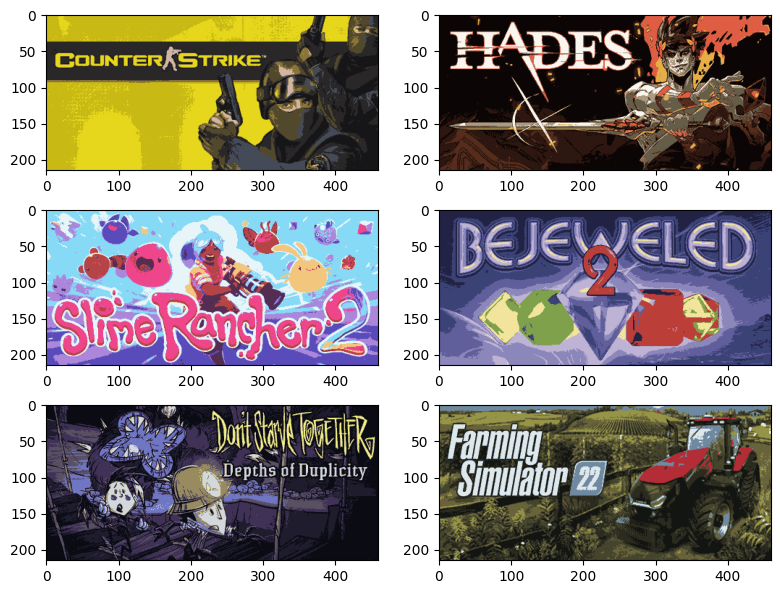

In [9]:
knn_images = []

for img_idx in example_ids:
    flat_lab = rgb_to_lab(images[keys[img_idx]]).reshape(-1, 3)
    top_colors = knn_colors[keys[img_idx]]

    knn_image = replace_colors(flat_lab, top_colors)
    knn_image = knn_image.reshape(images[keys[img_idx]].shape).astype(np.uint8)
    knn_image = cv2.cvtColor(knn_image, cv2.COLOR_LAB2RGB) # Back to RGB

    knn_images.append(knn_image)

print(f"Quantization: k={k}")
show_images(knn_images)

***Genre Exploration***

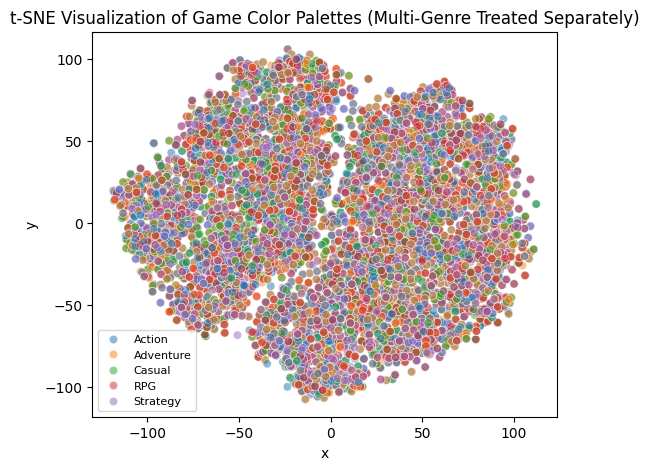

In [ ]:
def plot_color_tsne(knn_colors, game_genres, genre_filter=None):
    """t-SNE to visualize dominant colors in 2D space"""
    
    color_vectors = []
    genres = []
    
    for app_id, idx in keys.items():
        colors = knn_colors[idx].flatten()  # Flatten color vector
        
        for genre in game_genres.get(app_id, []):
            if genre_filter is None or genre in genre_filter:
                color_vectors.append(colors)
                genres.append(genre)

    color_vectors = np.array(color_vectors)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(color_vectors)

    df = pd.DataFrame({
        "x": embeddings[:, 0],
        "y": embeddings[:, 1],
        "genre": genres,
    })

    # Plot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df, x="x", y="y", hue="genre", palette="tab10", alpha=0.5)
    plt.title("t-SNE Visualization of Game Color Palettes (Multi-Genre Treated Separately)")
    plt.legend(loc="best", fontsize=8)
    plt.show()

game_genres = genres.groupby("app_id").genre.apply(list).to_dict()

plot_color_tsne(knn_colors, game_genres,
                {"Action", "Adventure", "Casual", "RPG", "Strategy"})

## Color Distribution (Histogram Analysis)

***Computation***

In [12]:
# Compute color histograms for all images in the dataset
color_histograms = [[] for _ in range(3)]

for img in images:
    # Split channels
    r_hist = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()
    g_hist = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
    b_hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    
    # Normalize histograms (optional)
    r_hist /= r_hist.sum()
    g_hist /= g_hist.sum()
    b_hist /= b_hist.sum()
    
    # Store data
    color_histograms[0].append(r_hist)
    color_histograms[1].append(g_hist)
    color_histograms[2].append(b_hist)

# Convert lists to NumPy arrays
for i in range(3):
    color_histograms[i] = np.array(color_histograms[i])
color_histograms = np.array(color_histograms)
color_histograms = np.transpose(color_histograms, axes=[1, 0, 2])

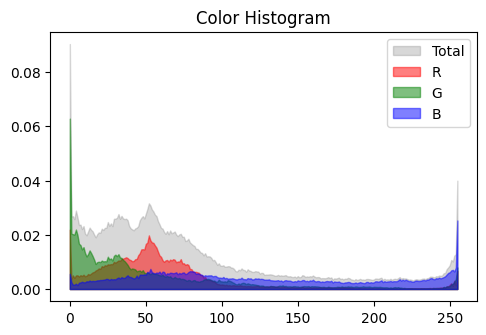

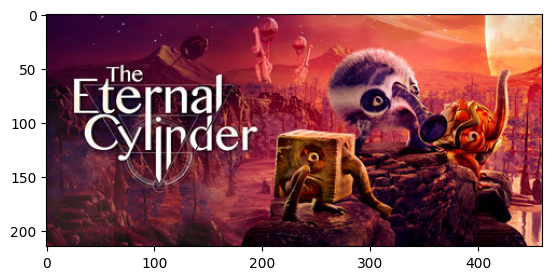

In [13]:
img_idx = 2

y = color_histograms[img_idx]
x = np.arange(y.shape[1])
y_tot = y.sum(axis=0)

plt.figure(figsize=(5.5, 3.5))
plt.fill_between(x, y_tot, color="gray", alpha=0.3, label="Total")
plt.fill_between(x, y[0], color="red", alpha=0.5, label="R")
plt.fill_between(x, y[1], color="green", alpha=0.5, label="G")
plt.fill_between(x, y[2], color="blue", alpha=0.5, label="B")
plt.title("Color Histogram")
plt.legend()
plt.show()

plt.imshow(images[img_idx])

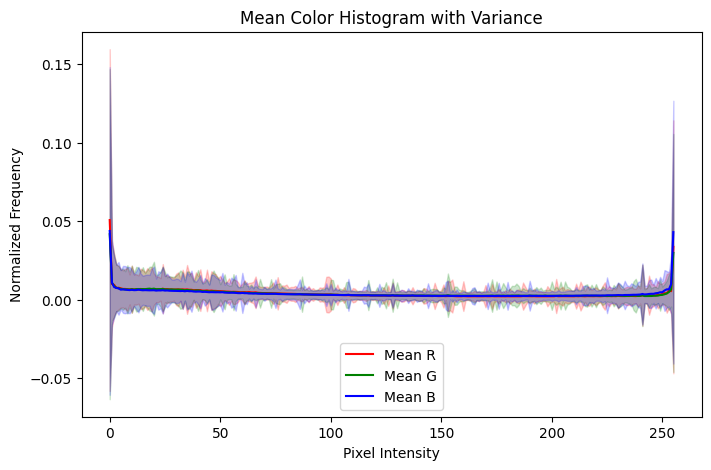

In [ ]:
# Compute mean and variance
mean_hist = np.mean(color_histograms, axis=0)
var_hist = np.var(color_histograms, axis=0)

colors = ['r', 'g', 'b']
plt.figure(figsize=(8, 5))

for i, color in enumerate(colors):
    plt.plot(mean_hist[i], color=color, label=f'Mean {color.upper()}')
    plt.fill_between(range(256), mean_hist[i] - np.sqrt(var_hist[i]), mean_hist[i] + np.sqrt(var_hist[i]),
                     color=color, alpha=0.2)

plt.title('Mean Color Histogram with Variance')
plt.xlabel('Pixel Intensity')
plt.ylabel('Normalized Frequency')
plt.gca().set_axisbelow(True)
plt.legend()
plt.show()

***Genres and Concurrent User Clustering***

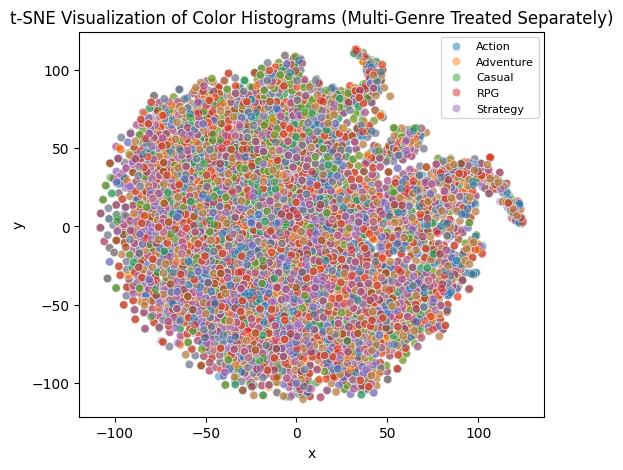

In [ ]:
def plot_histogram_tsne(color_histograms, game_genres, genre_filter=None):
    """t-SNE visualization of color histograms in 2D space"""
    
    hist_vectors = []
    genres = []

    for app_id, idx in keys.items():
        hist = color_histograms[idx].flatten()  # Flatten histogram vector
        
        for genre in game_genres.get(app_id, []):
            if genre_filter is None or genre in genre_filter:
                hist_vectors.append(hist)
                genres.append(genre)

    hist_vectors = np.array(hist_vectors)

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(hist_vectors)

    df = pd.DataFrame({
        "x": embeddings[:, 0],
        "y": embeddings[:, 1],
        "genre": genres,
    })

    # Plot t-SNE embeddings
    plt.figure(figsize=(6, 5))
    sns.scatterplot(data=df, x="x", y="y", hue="genre", palette="tab10", alpha=0.5)
    plt.title("t-SNE Visualization of Color Histograms (Multi-Genre Treated Separately)")
    plt.legend(loc="best", fontsize=8)
    plt.show()

# Convert game genres to a dictionary
game_genres = genres.groupby("app_id").genre.apply(list).to_dict()

# Call function with the same genre filter as before
plot_histogram_tsne(color_histograms, game_genres,
                    {"Action", "Adventure", "Casual", "RPG", "Strategy"})


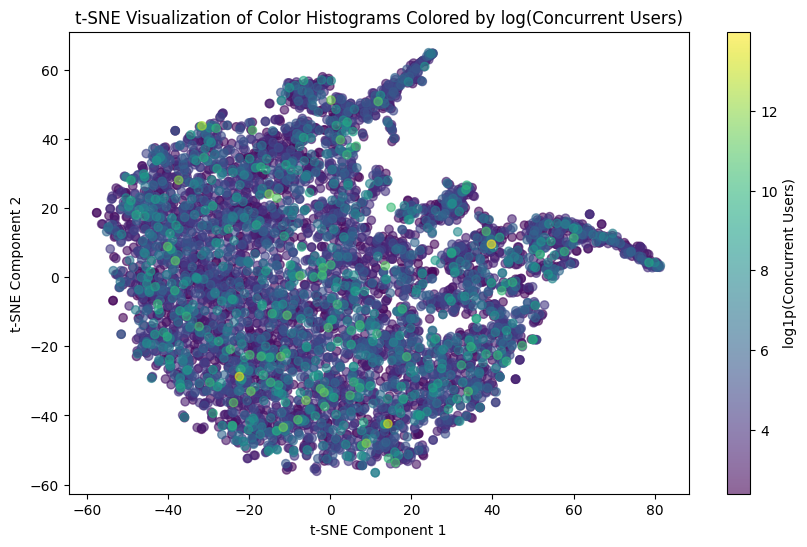

In [ ]:
def plot_histogram_tsne_users(color_histograms, user_counts):
    """t-SNE visualization of color histograms with color mapping based user count"""
    
    hist_vectors = []
    user_values = []

    for app_id, idx in keys.items():
        hist = color_histograms[idx].flatten()  # Flatten histogram vector
        
        if app_id in user_counts:  # Ensure data exists for this game
            hist_vectors.append(hist)
            user_values.append(user_counts[app_id])  # Continuous feature (e.g., user count)

    hist_vectors = np.array(hist_vectors)
    user_values = np.array(user_values)

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings = tsne.fit_transform(hist_vectors)

    df = pd.DataFrame({
        "x": embeddings[:, 0],
        "y": embeddings[:, 1],
        "users": user_values,
    })

    # Scatter plot with color gradient based on users
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(df["x"], df["y"], c=df["users"], cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="log(Concurrent Users + 1)")
    plt.title("t-SNE Visualization of Color Histograms Colored by log(Concurrent Users + 1)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# Convert log user counts to a dictionary
user_counts = spy.groupby("app_id")["concurrent_users_yesterday"].apply(lambda x: np.log1p(x).iloc[0]).to_dict()

plot_histogram_tsne_users(color_histograms, user_counts)

## Structural Analysis (PCA)

***Computation***

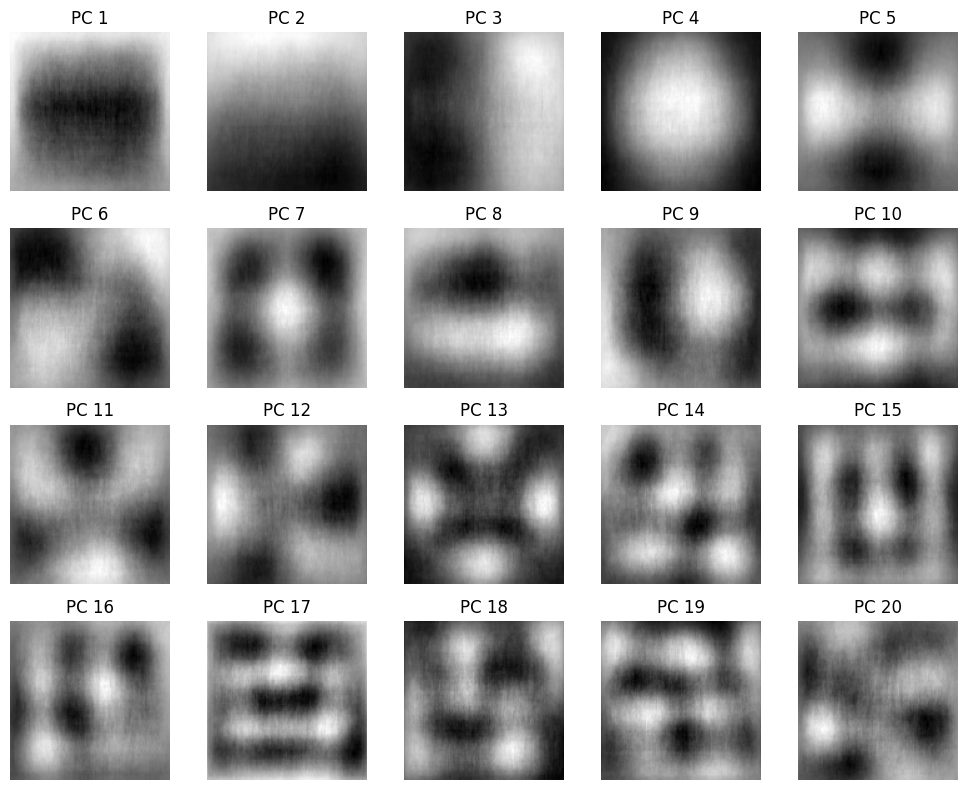

In [ ]:
EIG_SIZE = (128, 128)
EIG_COMPONENTS = 20

# Convert images to grayscale and flatten
eig = []

for img in images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized = cv2.resize(gray, EIG_SIZE)          # Resize to fixed size
    flattened = resized.flatten()                 # Flatten into 1D vector
    eig.append(flattened)

# Stack all images into a matrix (each row is an image)
image_matrix = np.stack(eig)

# Apply PCA
pca = PCA(n_components=EIG_COMPONENTS)
pca.fit(image_matrix)

# Visualize the top principal components (Eigenimages)
fig, axes = plt.subplots(EIG_COMPONENTS // 5, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    if i >= EIG_COMPONENTS:
        break
    eigenimage = pca.components_[i].reshape(EIG_SIZE)  # Reshape back to image
    ax.imshow(eigenimage, cmap='gray')
    ax.set_title(f'PC {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

# Project images onto principal components
pca_features = pca.transform(image_matrix)

***Genres and Users***

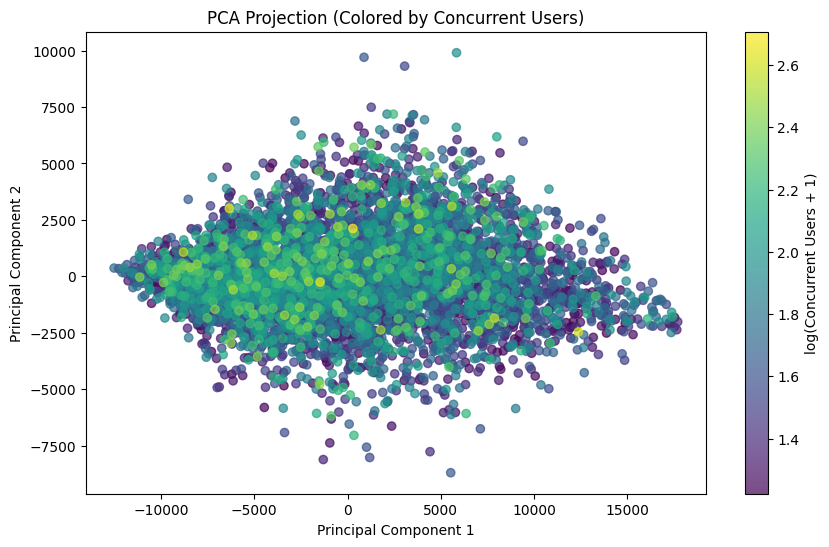

In [ ]:
# Get the first two principal components
pc1 = pca_features[:, 0]
pc2 = pca_features[:, 1]

# Map images to user counts (ensure the order is correct)
user_values = np.array([user_counts.get(app_id, 0) for app_id in keys])  # Match order

# Apply log scaling for better visualization
log_users = np.log1p(user_values)

# Scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pc1, pc2, c=log_users, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="log(Concurrent Users + 1)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection (Colored by Concurrent Users)")
plt.show()


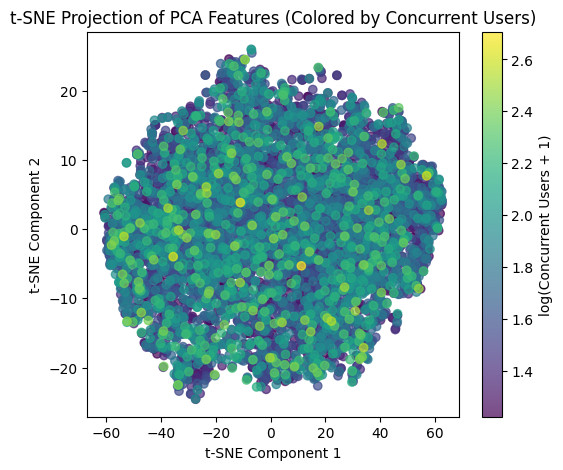

In [ ]:
# Reduce PCA features to 2D
tsne = TSNE(n_components=2, perplexity=60, random_state=42)
pca_tsne = tsne.fit_transform(pca_features)

# Map images to user counts
user_values = np.array([user_counts.get(app_id, 0) for app_id in keys])

# Apply log scaling
log_users = np.log1p(user_values)

# Scatter plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(pca_tsne[:, 0], pca_tsne[:, 1], c=log_users, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="log(Concurrent Users + 1)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Projection of PCA Features (Colored by Concurrent Users)")
plt.show()

## Signalling Colors

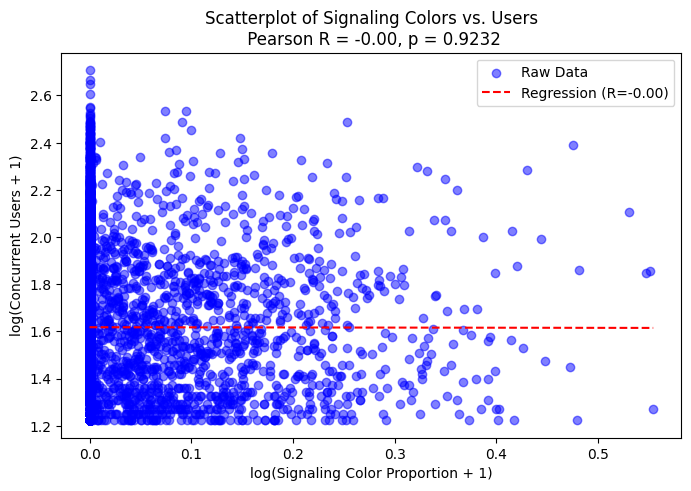

In [ ]:
# Compute regression on raw (non-binned) data
slope_raw, intercept_raw, r_value_raw, p_value_raw, std_err_raw = linregress(df["log_signaling"], df["log_users"])

# Generate regression line for raw data
x_range = np.linspace(df["log_signaling"].min(), df["log_signaling"].max(), 100)
y_fit_raw = slope_raw * x_range + intercept_raw

# Compute Pearson correlation on raw values (not binned)
pearson_corr, pearson_p = pearsonr(df["log_signaling"], df["log_users"])

# Scatter plot of raw data with regression line
plt.figure(figsize=(8, 5))
plt.scatter(df["log_signaling"], df["log_users"], alpha=0.5, color="blue", label="Raw Data")
plt.plot(x_range, y_fit_raw, color="red", linestyle="--", label=f"Regression (R={r_value_raw:.2f})")

# Labels and title
plt.xlabel("log(Signaling Color Proportion + 1)")
plt.ylabel("log(Concurrent Users + 1)")
plt.title(f"Scatterplot of Signaling Colors vs. Users\n Pearson R = {pearson_corr:.2f}, p = {pearson_p:.4f}")
plt.legend()
plt.show()